# Ejercicio Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

#set up graphic style in this case I am using the color scheme from xkcd.com
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
LABELS = ["Normal","Fraud"]
#col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
#sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

%matplotlib inline

## Cargamos Datos

In [2]:
# Descargar desde https://www.kaggle.com/mlg-ulb/creditcardfraud/data

df = pd.read_csv("creditcard.csv")
df.head(n=5) 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape

(284807, 31)

## Vemos Desbalanceo

In [4]:
pd.value_counts(df['Class'], sort = True) #class comparison 0=Normal 1=Fraud

Class
0    284315
1       492
Name: count, dtype: int64

In [5]:
normal_df = df[df.Class == 0] #registros normales
fraud_df = df[df.Class == 1] #casos de fraude

## Creamos Dataset

In [6]:
y = df['Class']
X = df.drop('Class', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [7]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

## Ejecutamos Modelo con LogisticRegresion para poder Comparar

In [9]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,
                             penalty='l2',
                             random_state=1,
                             solver="newton-cholesky",
                             class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)

### Veamos como responde en el test set

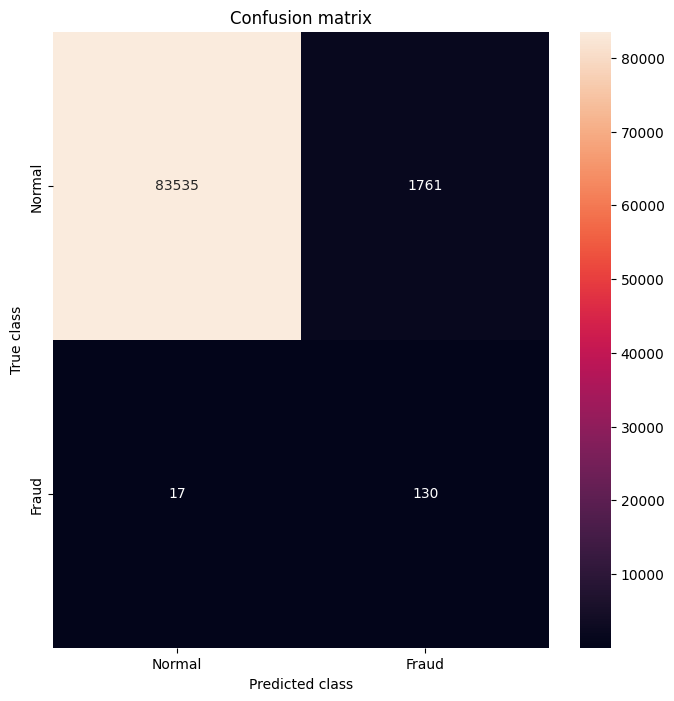

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85296
           1       0.07      0.88      0.13       147

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443



In [ ]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# Probamos con Random Forest

## ATENCION: Este modelo toma algo más de tiempo en entrenar

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Crear el modelo con 100 arboles
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,  # Each forest takes random samples to train
                               verbose=0,
                               max_features = 'sqrt')
# entrenar!
model.fit(X_train, y_train)

RandomForestClassifier()

### Revisemos los resultados

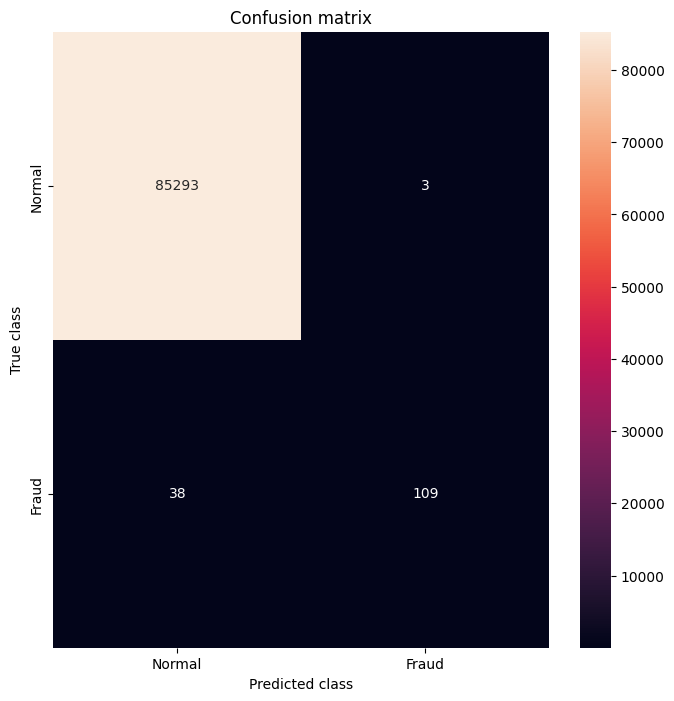

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.97      0.74      0.84       147

    accuracy                           1.00     85443
   macro avg       0.99      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [13]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# Otro Bosque: Random Forest -más veloz-

In [14]:
# otro modelo, variando hiperparámetros
model = RandomForestClassifier(n_estimators=100, class_weight="balanced",
                               max_features = 'sqrt', verbose=0,
                               max_depth=6,
                               oob_score=True,
                               random_state=50)
# a entrenar
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, oob_score=True,
                       random_state=50)

## Veamos la Confusion Matrix con el conjunto de Test

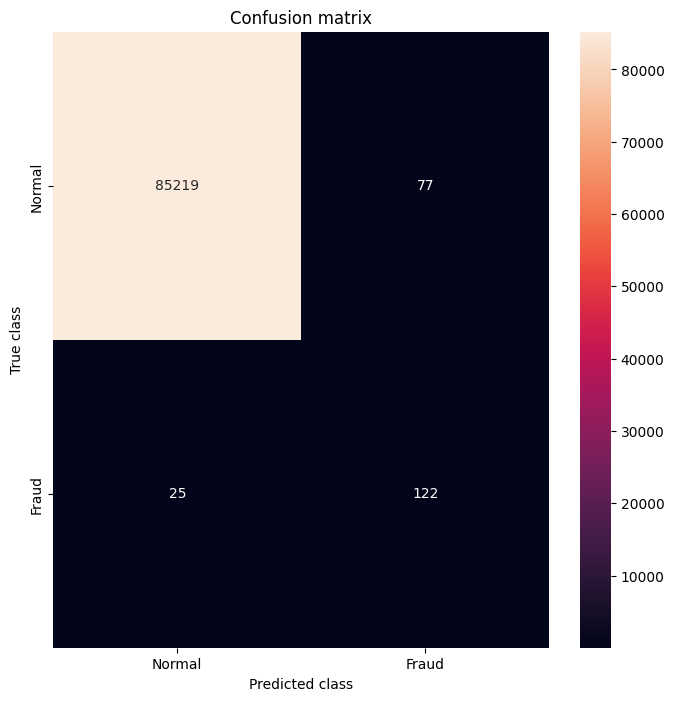

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.61      0.83      0.71       147

    accuracy                           1.00     85443
   macro avg       0.81      0.91      0.85     85443
weighted avg       1.00      1.00      1.00     85443



In [15]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

# Comprobamos Resultados

In [16]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, pred_y)

In [17]:
print(roc_value)

0.9145146170454677


El valor de roc cuanto más cerca de 1, mejor. si fuera 0.5 daría igual que fuesen valores aleatorios y sería un mal modelo